In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# データの読み込み
data = pd.read_csv('dataframe.csv')
X = data.iloc[:, :-1].values  # 入力データ (スピン配位)
y = data.iloc[:, -1].values   # 教師データ (温度)

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# NumPy配列からPyTorchのテンソルに変換
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # (25000,) -> (25000, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)    # (6250,) -> (6250, 1)

# y_trainテンソルを新しいテンソルに変換する関数を定義
def to_one_hot(y_train, num_classes=25):
    # one-hotベクトルの初期化
    one_hot = torch.zeros(len(y_train), num_classes)
    
    # 各要素を25次元のone-hotベクトルに変換
    for i, val in enumerate(y_train):
        index = int((val - 0.01) / 0.24)  # 正しいインデックスの計算
        one_hot[i, index] = 1.0
    
    return one_hot

# y_train,y_testをone-hotベクトルに変換
one_hot_y_train = to_one_hot(y_train, num_classes=25)
one_hot_y_test = to_one_hot(y_test, num_classes=25)

# データセットの作成
train_dataset = TensorDataset(X_train, one_hot_y_train)
test_dataset = TensorDataset(X_test, one_hot_y_test)

# DataLoaderの設定（バッチサイズ500）
train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=500)

# ニューラルネットワークモデルの定義
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

# モデルの初期化
input_size = 100
hidden_size = 64
output_size = 25
model = NeuralNetwork(input_size, hidden_size, output_size)

# 損失関数と最適化アルゴリズムの設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 学習の実行
num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()  # モデルを学習モードに設定
    for inputs, targets in train_loader:
        optimizer.zero_grad()       # 勾配を初期化
        outputs = model(inputs)     # フォワードパス
        loss = criterion(outputs, targets)
        loss.backward()            # バックプロパゲーション
        optimizer.step()           # パラメータの更新

    model.eval()   # モデルを評価モードに設定
    with torch.no_grad():
        test_loss = 0.0
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    train_losses.append(loss.item())
    test_losses.append(test_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}],  Test Loss: {test_loss:.4f}')

Epoch [1/100],  Test Loss: 3.2130
Epoch [2/100],  Test Loss: 3.2107
Epoch [3/100],  Test Loss: 3.2099
Epoch [4/100],  Test Loss: 3.2094
Epoch [5/100],  Test Loss: 3.2090
Epoch [6/100],  Test Loss: 3.2086
Epoch [7/100],  Test Loss: 3.2081
Epoch [8/100],  Test Loss: 3.2076
Epoch [9/100],  Test Loss: 3.2071
Epoch [10/100],  Test Loss: 3.2067
Epoch [11/100],  Test Loss: 3.2061
Epoch [12/100],  Test Loss: 3.2055
Epoch [13/100],  Test Loss: 3.2049
Epoch [14/100],  Test Loss: 3.2044
Epoch [15/100],  Test Loss: 3.2037
Epoch [16/100],  Test Loss: 3.2031
Epoch [17/100],  Test Loss: 3.2024
Epoch [18/100],  Test Loss: 3.2019
Epoch [19/100],  Test Loss: 3.2014
Epoch [20/100],  Test Loss: 3.2010
Epoch [21/100],  Test Loss: 3.2004
Epoch [22/100],  Test Loss: 3.2000
Epoch [23/100],  Test Loss: 3.1998
Epoch [24/100],  Test Loss: 3.1996
Epoch [25/100],  Test Loss: 3.1992
Epoch [26/100],  Test Loss: 3.1990
Epoch [27/100],  Test Loss: 3.1988
Epoch [28/100],  Test Loss: 3.1985
Epoch [29/100],  Test Loss: 3

Final Test Loss: 3.1962


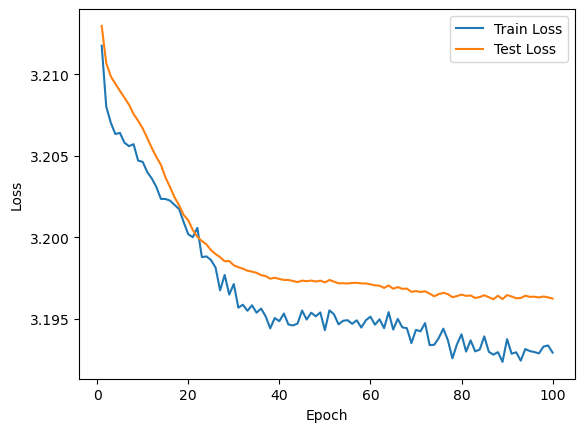

In [2]:
# モデルの評価
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, one_hot_y_test)    # 修正
    print(f'Final Test Loss: {test_loss:.4f}')

# 損失の可視化
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

temperature =  0.75
prediction(average) =  0.42
prediction(maximum) =  0.25


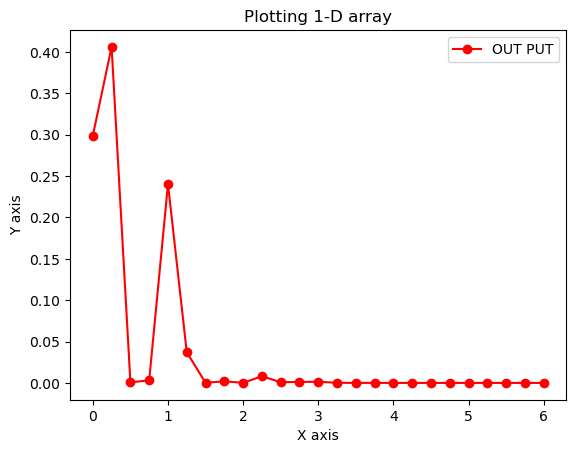

In [8]:
# テストデータに対する推測値
y_pred = model(X_test)

# 温度の予測を可視化するために pytorch tensor から ndarray へ変換
y_pred_np = y_pred.to('cpu').detach().numpy().copy()

# j 番目のテストデータと推測値の比較
j = 8
print('temperature = ', y_test[j].item())
x = np.arange(25)/4
y = y_pred_np[j]    # X に対する出力
print('prediction(average) = ', f'{np.dot(x,y):.2f}')
print('prediction(maximum) = ', f'{np.argmax(y)/4:.2f}')
plt.title("Plotting 1-D array")
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.plot(x, y, color = "red", marker = "o", label = "OUT PUT")
plt.legend()
plt.show()

In [19]:
x

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
       5.5 , 5.75, 6.  ])

In [20]:
y

array([3.6468322e-03, 6.2127510e-04, 8.3860703e-02, 2.9185216e-04,
       1.7521371e-03, 9.7169034e-04, 2.5262544e-03, 1.6102498e-02,
       1.1259584e-03, 1.2545847e-02, 6.2786450e-04, 1.2416416e-04,
       7.6572835e-03, 1.2529718e-03, 2.6388986e-03, 1.4515306e-04,
       1.3311326e-03, 2.0615881e-02, 2.9686126e-03, 4.2972274e-02,
       6.1325695e-02, 1.0657530e-01, 6.2820691e-01, 3.8908536e-05,
       7.3874733e-05], dtype=float32)

In [21]:
np.dot(x,y)

4.778828598288783

In [38]:
np.argmax(y)

17